# Setting up notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras import Sequential,Model
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import os
from tensorflow.keras.backend import flatten
import tensorflow.keras.backend as K


2024-08-16 16:54:33.831351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 16:54:33.845051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 16:54:33.848766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 16:54:33.859698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 16:54:34.842622: W tensorflow/compiler/tf2

# Prepare data generator (no augmentation)

In [2]:
import pathlib

data_dir = '/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/data/images/'
mask_dir = '/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/data/segmentation_images/'

all_images = os.listdir(data_dir)

to_train = 0.1 # ratio of number of train set images to use
total_train_images = all_images[:int(len(all_images)*to_train)]

WIDTH = 448  #  actual : 600 divisible by 64
HEIGHT = 448 # actual : 450
BATCH_SIZE = 2

In [3]:
# split train set and test set
train_images, validation_images = train_test_split(total_train_images, train_size=0.8, test_size=0.2,random_state = 0)

In [4]:
# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images, tuple
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = original_img.resize(dims)
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_segmentation.png')
                resized_mask = original_mask.resize(dims)
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])

            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

In [5]:
# generator that we will use to read the data from the directory with random augmentation
def data_gen_aug(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images, tuple
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # read images and masks
                original_img = load_img(data_dir + images[i])
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_segmentation.png')
                
                # transform into ideal sizes
                resized_img = original_img.resize(dims)
                resized_mask = original_mask.resize(dims)
              
                # add random augmentation > here we only flip horizontally
                if np.random.random() < 0.5:
                  resized_img = resized_img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                  resized_mask = resized_mask.transpose(PIL.Image.FLIP_LEFT_RIGHT)

                array_img = img_to_array(resized_img)/255
                array_mask = img_to_array(resized_mask)/255

                imgs.append(array_img)
                labels.append(array_mask[:, :, 0])
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

In [6]:
#generator for train and validation data set
train_gen = data_gen_aug(data_dir, mask_dir, train_images, BATCH_SIZE, (WIDTH, HEIGHT))
val_gen = data_gen_small(data_dir, mask_dir, validation_images, BATCH_SIZE, (WIDTH, HEIGHT))

# Set up Unet model

Define down and up layers that will be used in Unet model

In [7]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2  

In [8]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [WIDTH, HEIGHT, 3])
layers = [input_layer]
residuals = []

# Down 1
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5
d5 = down(d4, filters, pool=False)

# Up 1
up1 = up(d5, residual=residuals[-1], filters=filters/2)
filters /= 2

# Up 2
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

I0000 00:00:1723820076.701246    2951 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723820076.842708    2951 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723820076.842791    2951 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723820076.848322    2951 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723820076.848403    2951 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 448, 448,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 448, 448,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │  2,097,664 │ up_sampling2d[0]

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Now let's use Tensorflow to write our own dice_coeficcient metric, which is a effective indicator of how much two sets overlap with each other
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [10]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/models/checkpoint/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-6
                                   )

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Train model

Load weights and continue training

In [11]:
model.load_weights('/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/models/checkpoint/cp-0022.weights.h5')

In [12]:
model.compile(optimizer = adam, loss = BinaryCrossentropy(), metrics=['accuracy',dice_coef])

In [13]:
# model.fit(train_gen, callbacks=[cp_callback,early_stop,reduce_lr],
#                     steps_per_epoch=int(np.ceil(float(len(train_images)) / float(BATCH_SIZE))),
#                     epochs=100,
#                     validation_steps=int(np.ceil(float(len(validation_images)) / float(BATCH_SIZE))),
#                     validation_data = val_gen)

In [14]:
#model.save('/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/models/uNet_segmentation_predictor.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction shape: (448, 448)
Prediction min value: False
Prediction max value: True


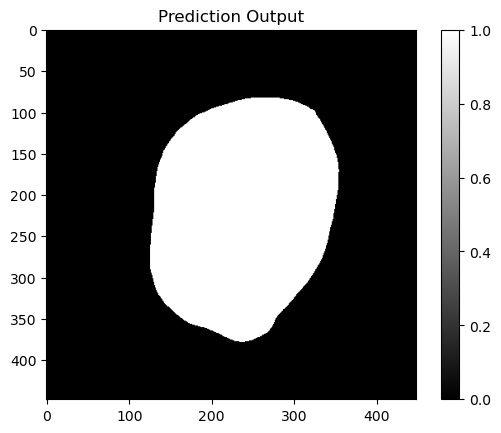

In [29]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(model, image_path, target_size=(448, 448)):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Expand dimensions to create a batch of size (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image (scaling to [0,1])
    img_array = img_array / 255.0
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Reshape the output to (448, 448)
    reshaped_prediction = prediction.squeeze()
    
    return reshaped_prediction > 0.3

# Usage
image_path = '/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/data/images/ISIC_0034318.jpg'
WIDTH, HEIGHT = 448, 448  # Adjusted to match your model's output size

# Make prediction
prediction = predict_single_image(model, image_path, target_size=(WIDTH, HEIGHT))

print(f"Prediction shape: {prediction.shape}")
print(f"Prediction min value: {prediction.min()}")
print(f"Prediction max value: {prediction.max()}")

# If you want to visualize the prediction (assuming it's an image-like output)
import matplotlib.pyplot as plt

plt.imshow(prediction, cmap='gray')
plt.colorbar()
plt.title('Prediction Output')
plt.show()

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/data/images/'
train_date_gen = test_datagen.flow_from_directory(
        train_dir,
        target_size=(WIDTH, HEIGHT),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=BATCH_SIZE)

filenames = train_date_gen.filenames
nb_samples = len(filenames)

Found 3 images belonging to 1 classes.


In [31]:
train_ids = [fn.split('\\')[-1][:-4] for fn in filenames]

In [33]:
predict = model.predict(train_date_gen ,steps = 
                                   int(np.ceil(nb_samples/BATCH_SIZE)))

/home/papafrita/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723813888.506090   11420 service.cc:146] XLA service 0x7fc09800cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723813888.506840   11420 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-08-16 15:11:28.585039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 15:11:28.801784: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cu

1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step

I0000 00:00:1723813896.277904   11420 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


In [17]:
plt.imshow(predict[0])

NameError: name 'predict' is not defined

In [45]:
import PIL.Image as Image

Image.open(predict[0])

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [121]:
def get_predicted_img(output,DIM = (WIDTH, HEIGHT)):
    data = np.reshape(output,DIM)
    mask = data > 0.7
    return np.asarray(Image.fromarray(mask, 'L'))

get_predicted_img(predict[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

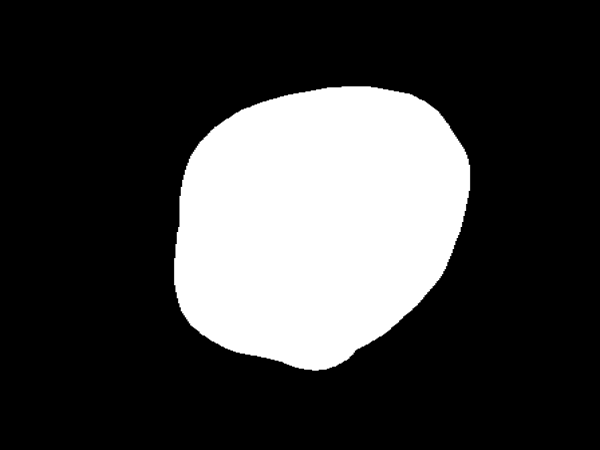

In [122]:
def get_img_resize(fname, DIM = (WIDTH, HEIGHT)):
    img_pil = Image.fromarray(fname*255, 'L')
    mask = img_pil.resize(DIM)
    return mask

get_img_resize(get_predicted_img(predict[0]), (600, 450))

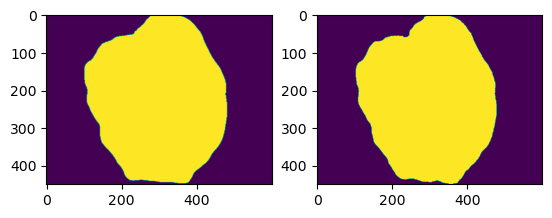

In [125]:
fig, axs = plt.subplots(ncols=2)

import matplotlib.image as mpimg
img = mpimg.imread('/home/papafrita/Projects/skin_cancer_tool/Skin_cancer_diagnosis_tool/data/segmentation_images/ISIC_0034320_segmentation.png')

axs[0].imshow(get_img_resize(get_predicted_img(predict[2]), (600, 450)))
axs[1].imshow(img)